Dataset statistics:
Number of face images is 435
Number of face IDs is 435
Number of background images is 467


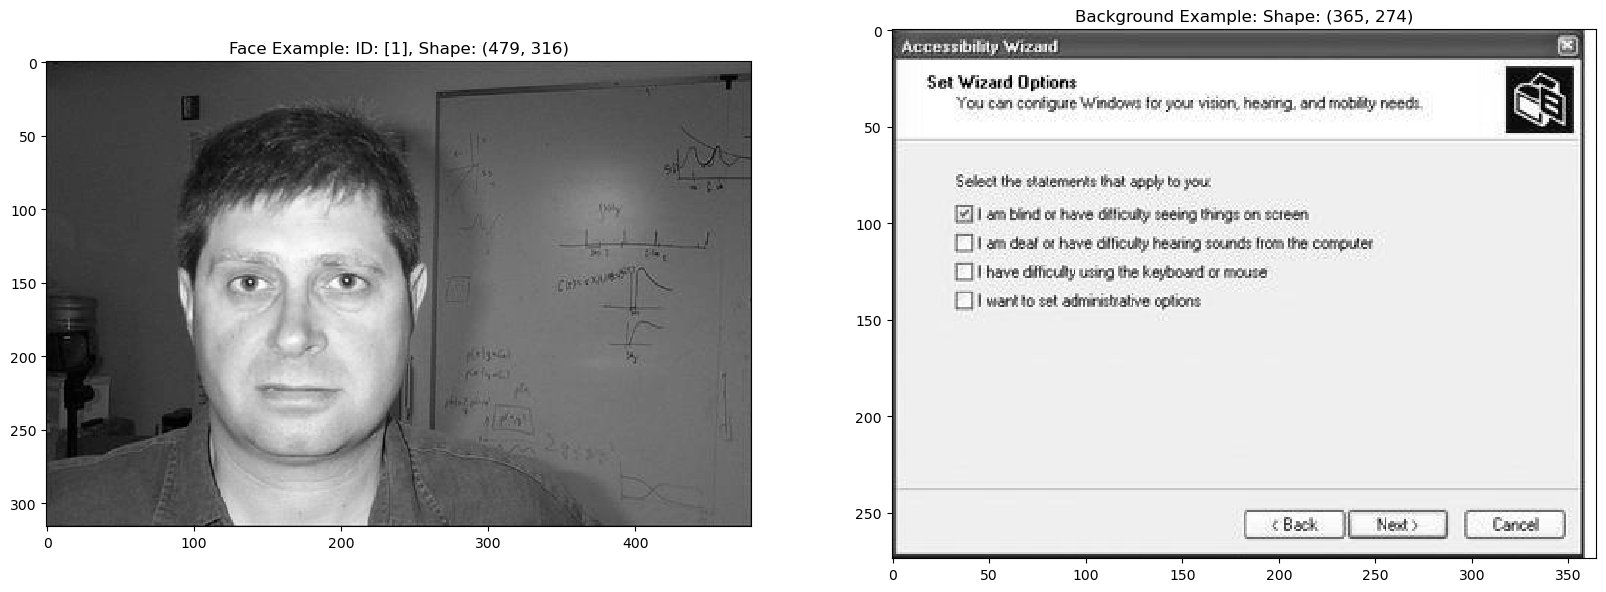

In [129]:
# Step 1 Dataset
import os 
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import torch.nn.functional as F

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def load_data(data_folder_path):
    back_imgs = []
    face_imgs = []
    face_ids = []
    
    column_name = ['FILENAME', 'FACEID'] 
    face_image_id_table = pd.read_csv(os.path.join(data_folder_path, "face_id.csv"), names=column_name, header=None)
    
    for idx in face_image_id_table.index:
        path2img = os.path.join(data_folder_path, "Faces", face_image_id_table[column_name[0]][idx])
        im = Image.open(path2img)
        face_imgs.append(ImageOps.grayscale(im))
        face_ids.append(face_image_id_table[column_name[1]][idx])

    for filename in os.listdir(os.path.join(data_folder_path, 'BACKGROUND_Google')):
        if filename.endswith(".jpg"):
            im = Image.open(os.path.join(data_folder_path, 'BACKGROUND_Google', filename))
            back_imgs.append(ImageOps.grayscale(im))

    face_ids = np.array(face_ids).reshape(len(face_ids), 1)
    
    return face_imgs, face_ids, back_imgs

def reshape_images(images, new_size):
    new_imgs = []
    for img in images:
        new_img = img.resize(new_size)
        new_imgs.append(new_img)
    return new_imgs

def flatten_norm_imgs(images):
    new_imgs = []
    for img in images:
        img_array = np.array(img).flatten() / 255.0
        new_imgs.append(img_array)
    return np.array(new_imgs)

def split_faces(face_images, face_ids, training_ratio):
    m = len(face_images)
    number_training_samples_based_on_ratio = int(m * training_ratio)
    unique_ids = np.unique(face_ids)

    cumulative_proportion = np.cumsum([np.sum(face_ids == id) for id in unique_ids]) / number_training_samples_based_on_ratio
    split_face_id = np.argmax(cumulative_proportion > 1)
    
    train_face_ids = unique_ids[:split_face_id]
    val_face_ids = unique_ids[split_face_id:]

    train_faces = [face_images[i].reshape(-1, 1) for i in range(len(face_ids)) if face_ids[i] in train_face_ids]
    val_faces = [face_images[i].reshape(-1, 1) for i in range(len(face_ids)) if face_ids[i] in val_face_ids]

    train_faces = np.hstack(train_faces) if train_faces else np.empty((100, 0))
    val_faces = np.hstack(val_faces) if val_faces else np.empty((100, 0))
    
    return train_faces, val_faces

def split_background(back_images, training_ratio):
    number_training_samples_based_on_ratio = int(len(back_images) * training_ratio)
    back_images = np.array(back_images).T
    
    train_backs, val_backs = back_images[:, :number_training_samples_based_on_ratio], back_images[:, number_training_samples_based_on_ratio:]
    
    return train_backs, val_backs

def generate_final_train_val_sets(face_images, face_ids, back_images, training_ratio=0.70):
    train_faces, val_faces = split_faces(face_images, face_ids, training_ratio)
    train_back, val_back = split_background(back_images, training_ratio)
    
    train_x = np.concatenate((train_faces, train_back), axis=1)
    train_y = np.zeros((1, train_x.shape[1]))
    train_y[:, :train_faces.shape[1]] = 1

    val_x = np.concatenate((val_faces, val_back), axis=1)
    val_y = np.zeros((1, val_x.shape[1]))
    val_y[:, :val_faces.shape[1]] = 1
    
    return train_x, train_y, val_x, val_y

def pre_process_dataset(orig_face_imgs, face_ids, orig_back_imgs, new_img_size):
    resized_face_imgs = reshape_images(orig_face_imgs, new_img_size)
    resized_back_imgs = reshape_images(orig_back_imgs, new_img_size)

    flat_face_imgs = flatten_norm_imgs(resized_face_imgs)
    flat_back_imgs = flatten_norm_imgs(resized_back_imgs)

    train_x_orig, train_y, val_x_orig, val_y = generate_final_train_val_sets(flat_face_imgs, face_ids, flat_back_imgs)

    return train_x_orig, train_y, val_x_orig, val_y

path_to_data_folder = "./data"
orig_face_imgs, face_ids, orig_back_imgs = load_data(path_to_data_folder)

new_img_size = [50, 50]
train_x_orig, train_y, val_x_orig, val_y = pre_process_dataset(orig_face_imgs, face_ids, orig_back_imgs, new_img_size)

# Example of face and background images
face_index = 10
back_index = 30

# Convert numpy arrays to PyTorch tensors
train_x_tensor = torch.tensor(train_x_orig.T, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y.T, dtype=torch.float32)
train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_y_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

val_x_tensor = torch.tensor(val_x_orig.T, dtype=torch.float32)
val_y_tensor = torch.tensor(val_y.T, dtype=torch.float32)
val_dataset = torch.utils.data.TensorDataset(val_x_tensor, val_y_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(orig_face_imgs[face_index])
plt.title("Face Example: ID: " + str(face_ids[face_index]) + ", Shape: " + str(orig_face_imgs[face_index].size))
plt.subplot(1, 2, 2)
plt.imshow(orig_back_imgs[back_index])
plt.title("Background Example: Shape: " + str(orig_back_imgs[back_index].size))

print("Dataset statistics:")
print("Number of face images is " + str(len(orig_face_imgs)))
print("Number of face IDs is " + str(face_ids.shape[0]))
print("Number of background images is " + str(len(orig_back_imgs)))


In [130]:
#Step 2 Build 4-Layer Network
class NetWithoutDropout(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(NetWithoutDropout, self).__init__()
        # Define fully connected layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass through the network
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x
       
# Main function to train the network
def train_network(train_loader, validation_loader, model, criterion, optimizer, num_epochs=2000):
    train_accuracy = [] # Store training accuracy for each epoch
    validation_accuracy = [] # Store validation accuracy for each epoch

    for epoch in range(num_epochs):
        # training part of the model
        model.train()
        epoch_loss = 0
        n_correct = 0
        n_examples = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            logits = model(inputs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            predicted_labels = (logits > 0.5).float() # Convert logits to binary predictions
            n_correct += (predicted_labels == labels).sum().item()
            epoch_loss += loss.item()
            n_examples += labels.shape[0]

        train_accuracy.append(n_correct / n_examples) # Calculate and store training accuracy

        if epoch % 100 == 0:
            # Print training loss and accuracy every 100 epochs
            print(f"Epoch [{epoch}/{num_epochs}], Training Loss: {epoch_loss / n_examples}, Training Accuracy: {n_correct / n_examples}")

        # Evaluating the model
        model.eval()
        validation_loss = 0 
        n_correct = 0
        n_examples = 0
    
        for inputs, labels in validation_loader:
            with torch.no_grad():
                logits = model(inputs)
                loss = criterion(logits, labels)

            predicted_labels = (logits > 0.5).float()
            n_correct += (predicted_labels == labels).sum().item()
            validation_loss += loss.item()
            n_examples += labels.shape[0]

        validation_accuracy.append(n_correct / n_examples) # Calculate and store validation accuracy
        if epoch % 100 == 0:
            # Print training loss and accuracy every 100 epochs
            print(f"Epoch [{epoch}/{num_epochs}], Validation Loss: {validation_loss / n_examples}, Validation Accuracy: {n_correct / n_examples}")
    
    return train_accuracy, validation_accuracy

# Define the neural network architecture
input_size = train_x_orig.shape[0]
hidden_size1 = 51
hidden_size2 = 25
hidden_size3 = 15
output_size = 1

# Create the model
model = NetWithoutDropout(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
# Train the network
train_accuracy, validation_accuracy = train_network(train_loader, val_loader, model, criterion, optimizer, num_epochs=2000)

Epoch [0/2000], Training Loss: 0.011309541383858788, Training Accuracy: 0.5335515548281505
Epoch [0/2000], Validation Loss: 0.002393344628442194, Validation Accuracy: 0.4845360824742268
Epoch [100/2000], Training Loss: 0.009286490575381464, Training Accuracy: 0.762684124386252
Epoch [100/2000], Validation Loss: 0.002062496041104556, Validation Accuracy: 0.711340206185567
Epoch [200/2000], Training Loss: 0.004739878586388259, Training Accuracy: 0.8739770867430442
Epoch [200/2000], Validation Loss: 0.0015643076183869667, Validation Accuracy: 0.7903780068728522
Epoch [300/2000], Training Loss: 0.00543782013771772, Training Accuracy: 0.8445171849427169
Epoch [300/2000], Validation Loss: 0.001328564591424162, Validation Accuracy: 0.8350515463917526
Epoch [400/2000], Training Loss: 0.0012940177038531452, Training Accuracy: 0.9819967266775778
Epoch [400/2000], Validation Loss: 0.0014536753552885809, Validation Accuracy: 0.8419243986254296
Epoch [500/2000], Training Loss: 0.0003260838876915836

In [131]:
# Step 3 Regularization
# Train the network with different weight decay values
weight_decay_values = [0, 0.001, 0.01, 0.1]
results = {}

for weight_decay in weight_decay_values:
    # Create the model
    model = NetWithoutDropout(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
    # Define the optimizer with weight decay
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay=weight_decay)
    # Train the network
    train_accuracy, validation_accuracy = train_network(train_loader, val_loader, model, criterion, optimizer, num_epochs=2000)
    # Store the results
    results[weight_decay] = (train_accuracy, validation_accuracy)

# Print the results
for weight_decay, (train_acc, val_acc) in results.items():
    print(f"Weight Decay: {weight_decay}, Final Training Accuracy: {train_acc[-1]}, Final Validation Accuracy: {val_acc[-1]}")

Epoch [0/2000], Training Loss: 0.01153601737732583, Training Accuracy: 0.4664484451718494
Epoch [0/2000], Validation Loss: 0.002385400005222596, Validation Accuracy: 0.5154639175257731
Epoch [100/2000], Training Loss: 0.009406734117704601, Training Accuracy: 0.7479541734860884
Epoch [100/2000], Validation Loss: 0.00208784808817598, Validation Accuracy: 0.6872852233676976
Epoch [200/2000], Training Loss: 0.005029925933251014, Training Accuracy: 0.8723404255319149
Epoch [200/2000], Validation Loss: 0.0013634777560676496, Validation Accuracy: 0.8075601374570447
Epoch [300/2000], Training Loss: 0.0033623810412450627, Training Accuracy: 0.9263502454991817
Epoch [300/2000], Validation Loss: 0.0014787169871051697, Validation Accuracy: 0.8316151202749141
Epoch [400/2000], Training Loss: 0.0013490740648804632, Training Accuracy: 0.9770867430441899
Epoch [400/2000], Validation Loss: 0.00152000825839354, Validation Accuracy: 0.8213058419243986
Epoch [500/2000], Training Loss: 0.000497786953142934

In [132]:
# Step 3 Optimization
def train_with_optimizer(train_loader, model, criterion, optimizer, num_epochs=2000):
    train_accuracy, validation_accuracy = train_network(train_loader, val_loader, model, criterion, optimizer, num_epochs)
    #return {'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy}

# Step 3.1: SGD with momentum (0.9)
print("SGD with momentum (0.9)")
optimizer_sgd_momentum = SGD(model.parameters(), lr=0.005, momentum=0.9)
results_sgd_momentum = train_with_optimizer(train_loader, model, criterion, optimizer_sgd_momentum)
print(results_sgd_momentum)

SGD with momentum (0.9)
Epoch [0/2000], Training Loss: 0.006527374106811423, Training Accuracy: 0.8756137479541735
Epoch [0/2000], Validation Loss: 0.0016299594718566055, Validation Accuracy: 0.7766323024054983
Epoch [100/2000], Training Loss: 0.00420275001303459, Training Accuracy: 0.9083469721767594
Epoch [100/2000], Validation Loss: 0.0016553132599571726, Validation Accuracy: 0.8316151202749141
Epoch [200/2000], Training Loss: 0.000397608056054763, Training Accuracy: 0.9950900163666121
Epoch [200/2000], Validation Loss: 0.003573636828419269, Validation Accuracy: 0.8178694158075601
Epoch [300/2000], Training Loss: 0.0003272778607612253, Training Accuracy: 0.9967266775777414
Epoch [300/2000], Validation Loss: 0.003948694651888818, Validation Accuracy: 0.8213058419243986
Epoch [400/2000], Training Loss: 0.00031362097358267067, Training Accuracy: 0.9967266775777414
Epoch [400/2000], Validation Loss: 0.004326026873899899, Validation Accuracy: 0.8213058419243986
Epoch [500/2000], Training

In [133]:
# Step 3.2: Nesterov
print("Nesterov")
optimizer_nesterov = SGD(model.parameters(), lr=0.005, momentum=0.9, nesterov=True)
results_nesterov = train_with_optimizer(train_loader, model, criterion, optimizer_nesterov)
print(results_nesterov)

Nesterov
Epoch [0/2000], Training Loss: 1.64578051686229e-06, Training Accuracy: 1.0
Epoch [0/2000], Validation Loss: 0.005592539138400678, Validation Accuracy: 0.8041237113402062
Epoch [100/2000], Training Loss: 1.2521512456597994e-06, Training Accuracy: 1.0
Epoch [100/2000], Validation Loss: 0.005694492985702462, Validation Accuracy: 0.8075601374570447
Epoch [200/2000], Training Loss: 1.069523917643335e-06, Training Accuracy: 1.0
Epoch [200/2000], Validation Loss: 0.0057409547038914, Validation Accuracy: 0.8109965635738832
Epoch [300/2000], Training Loss: 8.912588775107628e-07, Training Accuracy: 1.0
Epoch [300/2000], Validation Loss: 0.005786838400404888, Validation Accuracy: 0.8144329896907216
Epoch [400/2000], Training Loss: 7.650944512526454e-07, Training Accuracy: 1.0
Epoch [400/2000], Validation Loss: 0.005840598922414878, Validation Accuracy: 0.8144329896907216
Epoch [500/2000], Training Loss: 6.79540181050074e-07, Training Accuracy: 1.0
Epoch [500/2000], Validation Loss: 0.00

In [134]:
# Step 3.3: ADAM
print("ADAM")
optimizer_adam = Adam(model.parameters(), lr=0.005)
results_adam = train_with_optimizer(train_loader, model, criterion, optimizer_adam)
print(results_adam)

ADAM
Epoch [0/2000], Training Loss: 0.07932356476782311, Training Accuracy: 0.5319148936170213
Epoch [0/2000], Validation Loss: 0.006931938256594734, Validation Accuracy: 0.5154639175257731
Epoch [100/2000], Training Loss: 0.0008261528600818201, Training Accuracy: 0.9901800327332242
Epoch [100/2000], Validation Loss: 0.0027377556279762506, Validation Accuracy: 0.8247422680412371
Epoch [200/2000], Training Loss: 0.0006563769388218363, Training Accuracy: 0.9918166939443536
Epoch [200/2000], Validation Loss: 0.0035633213331609246, Validation Accuracy: 0.8178694158075601
Epoch [300/2000], Training Loss: 0.0007423793206543169, Training Accuracy: 0.9918166939443536
Epoch [300/2000], Validation Loss: 0.004018029806130531, Validation Accuracy: 0.8109965635738832
Epoch [400/2000], Training Loss: 0.0006551263227436917, Training Accuracy: 0.9918166939443536
Epoch [400/2000], Validation Loss: 0.00453304302241794, Validation Accuracy: 0.8075601374570447
Epoch [500/2000], Training Loss: 0.0006555992

In [135]:
# Step 3.4: NADAM
print("NADAM")
optimizer_nadam = Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999))
results_nadam = train_with_optimizer(train_loader, model, criterion, optimizer_nadam)
print(results_nadam)

NADAM
Epoch [0/2000], Training Loss: 0.011340163440829214, Training Accuracy: 0.5335515548281505
Epoch [0/2000], Validation Loss: 0.0024018314286195943, Validation Accuracy: 0.4845360824742268
Epoch [100/2000], Training Loss: 0.011326348235291077, Training Accuracy: 0.5335515548281505
Epoch [100/2000], Validation Loss: 0.002387819216423428, Validation Accuracy: 0.4845360824742268
Epoch [200/2000], Training Loss: 0.011322903847733419, Training Accuracy: 0.5335515548281505
Epoch [200/2000], Validation Loss: 0.002394652448568967, Validation Accuracy: 0.4845360824742268
Epoch [300/2000], Training Loss: 0.011324390159301008, Training Accuracy: 0.5335515548281505
Epoch [300/2000], Validation Loss: 0.0024115392022935793, Validation Accuracy: 0.4845360824742268
Epoch [400/2000], Training Loss: 0.011303713103167945, Training Accuracy: 0.5335515548281505
Epoch [400/2000], Validation Loss: 0.0023919860112298396, Validation Accuracy: 0.4845360824742268
Epoch [500/2000], Training Loss: 0.0113129697

In [136]:
# Step 4 Add dropout masks to the network
class NetWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(NetWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout1 = nn.Dropout(p=0.5)  # Dropout layer after layer 2
        self.dropout2 = nn.Dropout(p=0.5)  # Dropout layer after layer 3

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout1(x)  # Applying dropout after layer 2
        x = self.relu(self.fc3(x))
        x = self.dropout2(x)  # Applying dropout after layer 3
        x = self.sigmoid(self.fc4(x))
        return x

# Create the model with dropout
model_with_dropout = NetWithDropout(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model_with_dropout.parameters(), lr=0.005)

# Train the network with dropout
train_accuracy_dropout, validation_accuracy_dropout = train_network(train_loader, val_loader, model_with_dropout, criterion, optimizer, num_epochs=2000)

Epoch [0/2000], Training Loss: 0.011652903451466912, Training Accuracy: 0.4664484451718494
Epoch [0/2000], Validation Loss: 0.0023925138503005823, Validation Accuracy: 0.5154639175257731
Epoch [100/2000], Training Loss: 0.010521110360634113, Training Accuracy: 0.6333878887070377
Epoch [100/2000], Validation Loss: 0.0022093983450296407, Validation Accuracy: 0.6632302405498282
Epoch [200/2000], Training Loss: 0.008664194134760606, Training Accuracy: 0.7364975450081833
Epoch [200/2000], Validation Loss: 0.001846059900788507, Validation Accuracy: 0.7285223367697594
Epoch [300/2000], Training Loss: 0.006424028871492551, Training Accuracy: 0.8461538461538461
Epoch [300/2000], Validation Loss: 0.0015091290793468042, Validation Accuracy: 0.8144329896907216
Epoch [400/2000], Training Loss: 0.004523012988305911, Training Accuracy: 0.9050736497545008
Epoch [400/2000], Validation Loss: 0.0014841382446157973, Validation Accuracy: 0.8281786941580757
Epoch [500/2000], Training Loss: 0.003239918359953

In [137]:
# Step 5 Perform hyperparameter tunning.
# Define different hyperparameter combinations to explore
learning_rates = [0.001, 0.005, 0.01]
momentums = [0.9, 0.95]
betas = [(0.9, 0.999), (0.95, 0.9995)]
hidden_sizes = [(51, 25, 15), (64, 32, 16)]
dropout_probabilities = [0.3, 0.5]
best_accuracy = 0
best_hyperparameters = {}

# Iterate over hyperparameter combinations
for lr in learning_rates:
    for momentum in momentums:
        for beta in betas:
            for hidden_size in hidden_sizes:
                for dropout_prob in dropout_probabilities:
                    print("Learning Rate: ", lr, " Momentum: ", momentum, " Beta: ", beta, " Hidden Size: ", hidden_size, " Dropout Probability: ", dropout_prob)
                    # Define the model with current hyperparameters
                    model = NetWithDropout(input_size, hidden_size[0], hidden_size[1], hidden_size[2], output_size)
                    # Define the optimizer with ADAM and current hyperparameters
                    optimizer = Adam(model.parameters(), lr=lr, betas=beta)
                    # Train the network
                    train_accuracy, validation_accuracy = train_network(train_loader, val_loader, model, criterion, optimizer, num_epochs=2000)
                    # Get the best validation accuracy
                    current_best_accuracy = max(validation_accuracy)
                    # Update the best accuracy and hyperparameters if the current combination performs better
                    if current_best_accuracy > best_accuracy:
                        best_accuracy = current_best_accuracy
                        best_hyperparameters = {
                            'learning_rate': lr,
                            'momentum': momentum,
                            'beta': beta,
                            'hidden_size': hidden_size,
                            'dropout_probability': dropout_prob
                        }

# Print the best hyperparameters and accuracy
print("Best Hyperparameters:")
print(best_hyperparameters)
print("Best Validation Accuracy:", best_accuracy)


Learning Rate:  0.001  Momentum:  0.9  Beta:  (0.9, 0.999)  Hidden Size:  (51, 25, 15)  Dropout Probability:  0.3
Epoch [0/2000], Training Loss: 0.011546169189696616, Training Accuracy: 0.48936170212765956
Epoch [0/2000], Validation Loss: 0.002360276135382374, Validation Accuracy: 0.4845360824742268
Epoch [100/2000], Training Loss: 0.0011183983705779338, Training Accuracy: 0.9885433715220949
Epoch [100/2000], Validation Loss: 0.002171543455615486, Validation Accuracy: 0.8247422680412371
Epoch [200/2000], Training Loss: 0.00035525069026346584, Training Accuracy: 0.9934533551554828
Epoch [200/2000], Validation Loss: 0.005630244913789415, Validation Accuracy: 0.8316151202749141
Epoch [300/2000], Training Loss: 0.004748872851681592, Training Accuracy: 0.8887070376432079
Epoch [300/2000], Validation Loss: 0.001929958661397298, Validation Accuracy: 0.7972508591065293
Epoch [400/2000], Training Loss: 3.9610928981016206e-05, Training Accuracy: 1.0
Epoch [400/2000], Validation Loss: 0.008147034